# Entanglement within the two registers

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from sympy import *
import random
from random import sample
import math

In [4]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return y
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 

In [5]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix[j][i]=1
             
    for ii in range(N, dim):
        matrix[ii][ii] = 1
             
    matrix = linalg.matrix_power(matrix, 2**power) 
        
    U = UnitaryGate(matrix)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [6]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [28]:
y = 13
N = 15 

partition = 2
#runs = 3  #mean over the same couple

n = math.ceil(math.log(N,2))
control = QuantumRegister(2*n, 'r1')
target  = QuantumRegister(n, 't1')
classic = ClassicalRegister(2*n, 'c')
bins = []
couples = []
histogram = []
rho_step =  3 + 1 

for i in range(2*n):
    for j in range(2*n):
        if i != j:
            bins.append([i,j])

#for l in range(56):                                                # range(len(bins)):

somma = np.zeros(rho_step)
#print(bins[l])
couple = [6,7]#bins[l] #random.sample(range(0, 2*n), partition)
couples.append(couple)
#print(couple)

#for j in range(runs):
circuit = QuantumCircuit(control, target, classic)
#couple = random.sample(range(0, 2*n), partition)
qubits = couple #+ [8,9,10,11] 

#print(qubits)
size = len(qubits)
label = 0
#circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
#circuit.barrier(3*n - 1)
circuit.h(range(2*n))
circuit.x(2*n + n -1)

#label += 1
#circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
for q in range(2*n):
    if q == 2*n - 1:
        label = 0
        circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
        circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)])
    else: 
        circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)]) 

label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])            

circuit.append(qft_dagger(2*n), range(2*n)) 

label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
circuit.measure(control, classic)

label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circuit, aer_sim)
qobj = assemble(t_qc)                                
results = aer_sim.run(qobj, shots = 1).result()
counts = results.get_counts()

labels = []
for i in range(len(counts)):
    labels.append(int(list(counts.keys())[i], 2))

negativities = []
for i in range(rho_step):
    density_matrix = results.data()['pho_%.1f' % (i)]
    conjugate = density_matrix.transpose()#_op
    product = np.matmul(conjugate, density_matrix) #_op
    root = np.sqrt(product)
    norm = root.trace()
    negativities.append((norm- 1)/2)

    #density_matrix_op = density_matrix.to_operator()
    #density_matrix_tr = density_matrix_op.transpose()
    #negativities.append( linalg.norm(density_matrix_tr, 1) - 1 )
    

#print(negativities)
#for i in range(len(negativities)):
#    somma[i] = somma[i] + negativities[i]
histogram.append(negativities)

circuit_prova = circuit
negativities = 0
counts = 0
results = 0
density_matrix = 0
circuit = 0
t_qc = 0
qobj = 0
#j += 1

#media = np.zeros(rho_step)
#for i in range(rho_step):
#    media[i] =  somma[i]/ 2#*runs

#histogram.append(media)
#print(media)
#media = 0
#somma = 0


C:\Users\giuli\AppData\Local\Temp\ipykernel_24228\3820026367.py:77: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  conjugate = density_matrix.transpose()#_op


In [1]:
first = [(1.580957587066223e-13-4.808205355714529e-44j), (1.580957587066223e-13-4.808205355714529e-44j), (1.5787371410169726e-13-1.5426847868827395e-17j), (1.1102230246251565e-16+0j)]
last = [(0.20710678118677084+6.598198566333826e-31j), (0.20710678118677084+6.598198566333826e-31j), (0.07206140281786311-8.705203348630306e-32j), -1.0252925880066652e-32j]
print(histogram)

NameError: name 'histogram' is not defined

#voglio vedere before and after in queste coppie 
bins[0],bins[48]
len(bins)

In [ ]:
dataBEF = np.zeros(len(bins))
dataAFT = np.zeros(len(bins))

for i in range(len(couples)):
    for ii in range(len(bins) ):
        if couples[i] == bins[ii]:
            dataBEF[ii] = histogram[i][1]
            dataAFT[ii] = histogram[i][2]
            #print(couples[i])
            #if histogram[i][1] < 0.1: dataBEF[ii] = dataBEF[ii] + 1 
            #if histogram[i][2] < 0.1: dataAFT[ii] = dataAFT[ii] + 1

C:\Users\giuli\AppData\Local\Temp\ipykernel_23696\693049990.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  dataBEF[ii] = histogram[i][1]
C:\Users\giuli\AppData\Local\Temp\ipykernel_23696\693049990.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  dataAFT[ii] = histogram[i][2]


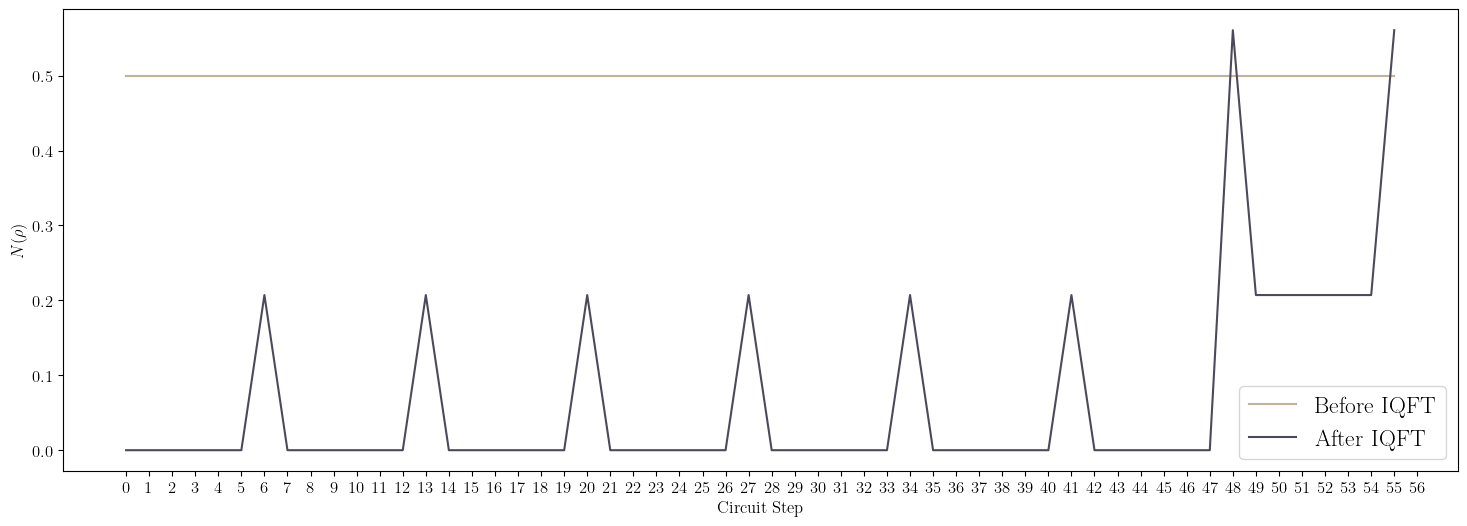

In [ ]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 6))
params = {'text.usetex' : True, 'font.size' : 12, 'font.family' : 'serif'}
plt.rcParams.update(params)

xs = []
for i in range(0, 57, 1):
    if i == 0 or i == 48:
        xs.append(i)
    else:
        xs.append(i)

plt.xticks(xs, fontsize = 12)
plt.xlabel('Circuit Step')
plt.ylabel(r"$N(\rho)$")
plt.plot(dataBEF,color = '#C3B299', label = 'Before IQFT')
plt.plot(dataAFT, color = '#4C495A', label = 'After IQFT')
plt.legend(fontsize=17)

plt.savefig('shor_traslationBIS.pdf', format = 'pdf')


In [ ]:
bins[6]

[0, 7]

# For a single couple

c:\Users\giuli\anaconda3\envs\quiskit\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


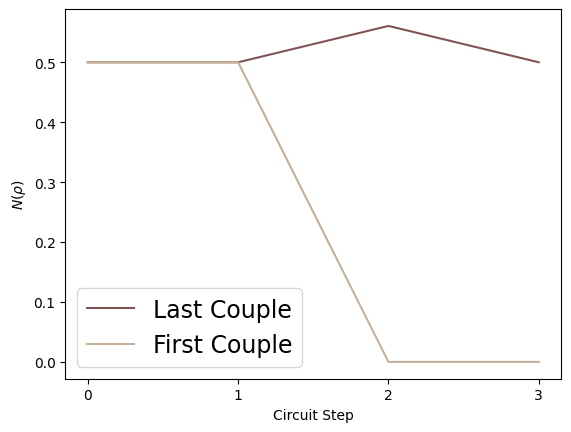

In [30]:
media01 = [(0.50000000000033-4.886720623100213e-16j), (0.50000000000033-4.886720623100213e-16j), (1.6353585152728556e-13+2.637535008768865e-16j), (1.7763568394002505e-15+2.506654178416944e-16j)]
media67 = [(0.5000000000003266+5.013308356835508e-16j), (0.5000000000003266+5.013308356835508e-16j), (0.5606601717802508-0.353553390593386j), (0.5000000000000044+1.623163417729189e-15j)]
xs = []
for i in range(0, 5, 1):
    xs.append(i)

plt.xlabel('Circuit Step')
plt.ylabel(r"$N(\rho)$")
plt.xticks(xs)
plt.plot(media67, label = 'Last Couple', color = '#815355')
plt.plot(media01, label = 'First Couple', color = '#C3B299')
plt.legend(fontsize=17)
plt.savefig('shor_traslation.pdf', format = 'pdf')

In [ ]:
circuit_prova.draw(fold=-1)